# Comparison against ABC

In [1]:
import corner
import glob
import hypothesis
import numpy as np
import matplotlib.pyplot as plt
import torch
import warnings

from hypothesis.stat import highest_density_level
from hypothesis.visualization.util import make_square
from matplotlib.colors import LogNorm
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import InterpolatedUnivariateSpline
from plotting import compute_1d_pdf
from plotting import compute_2d_pdf
from plotting import compute_1d_pdf_abc
from plotting import compute_2d_pdf_abc
from plotting import plot_1d_pdf
from plotting import plot_2d_pdf
from plotting import plot_1d_pdf_std
from plotting import plot_1d_contours
from plotting import plot_2d_contours
from plotting import plot_stream

from util import load_ratio_estimator
from tqdm import tqdm

In [2]:
warnings.filterwarnings('ignore')

In [3]:
# hypothesis.disable_gpu()

hypothesis.accelerator

device(type='cuda')

## Globals

In [4]:
datadir = "../experiment-simulations/data"       # Root directory containing the generated and observed data
phi = np.load(datadir + "/phi-cut.npy")          # Linear angle

## Load the ratio estimator

In [5]:
query = "out/coverage/4096/marginalized/selu/ratio-estimator-resnet-50*batchnorm-0*/best-model.th"
r_1d = load_ratio_estimator(query)

In [6]:
query = "out/coverage/4096/not-marginalized/selu/ratio-estimator-resnet-50*batchnorm-0*/best-model.th"
r_2d = load_ratio_estimator(query)

## Utilities

In [7]:
@torch.no_grad()
def plot_1d_contours(ax, pdf, height=0.0):
    n = len(pdf)
    masses = np.linspace(1, 50, n)
    # Compute the levels of the highest density regions
    level_1sigma = highest_density_level(pdf, 0.68)
    level_2sigma = highest_density_level(pdf, 0.95)
    level_3sigma = highest_density_level(pdf, 0.997, min_epsilon=10e-19)
    # Utility functions
    def clean_sign(signs):
        current = signs[0]
        for index in range(len(signs)):
            if signs[index] == 0:
                signs[index] = -current
            current = signs[index]

        return signs
    def plot(masses, level, color="black"):
        masses = masses.tolist()
        #masses.sort()
        edge_picked = False
        while len(masses) > 0:
            m = masses[0]
            end = None
            if pdf[0] > level and not edge_picked:
                edge_picked = True
                start = 1.
                end = m
            else:
                start = m
            masses.pop(0)
            if pdf[-1] > level and end is None:
                end = 50. - 0.01
            if end is None:
                end = masses[0]
                masses.pop(0)
            ax.plot([start, end], [height, height], lw=5, color=color)
    # Compute the intersections
    indices = np.argwhere(np.diff(clean_sign(np.sign(level_3sigma - pdf)), axis=0).reshape(-1)).flatten()
    m_1 = masses[indices]
    plot(m_1, level_3sigma, color="#dddddd")
    indices = np.argwhere(np.diff(clean_sign(np.sign(level_2sigma - pdf)), axis=0).reshape(-1)).flatten()
    m_2 = masses[indices]
    plot(m_2, level_2sigma, color="#aaaaaa")
    indices = np.argwhere(np.diff(clean_sign(np.sign(level_1sigma - pdf)), axis=0).reshape(-1)).flatten()
    m_3 = masses[indices]
    plot(m_3, level_1sigma, color="black")

    return m_1, m_2, m_3

# Plot

In [8]:
import palettable

cmap = palettable.scientific.sequential.Oslo_3.mpl_colormap
extent = [[1, 50], [3, 7]]

### First row

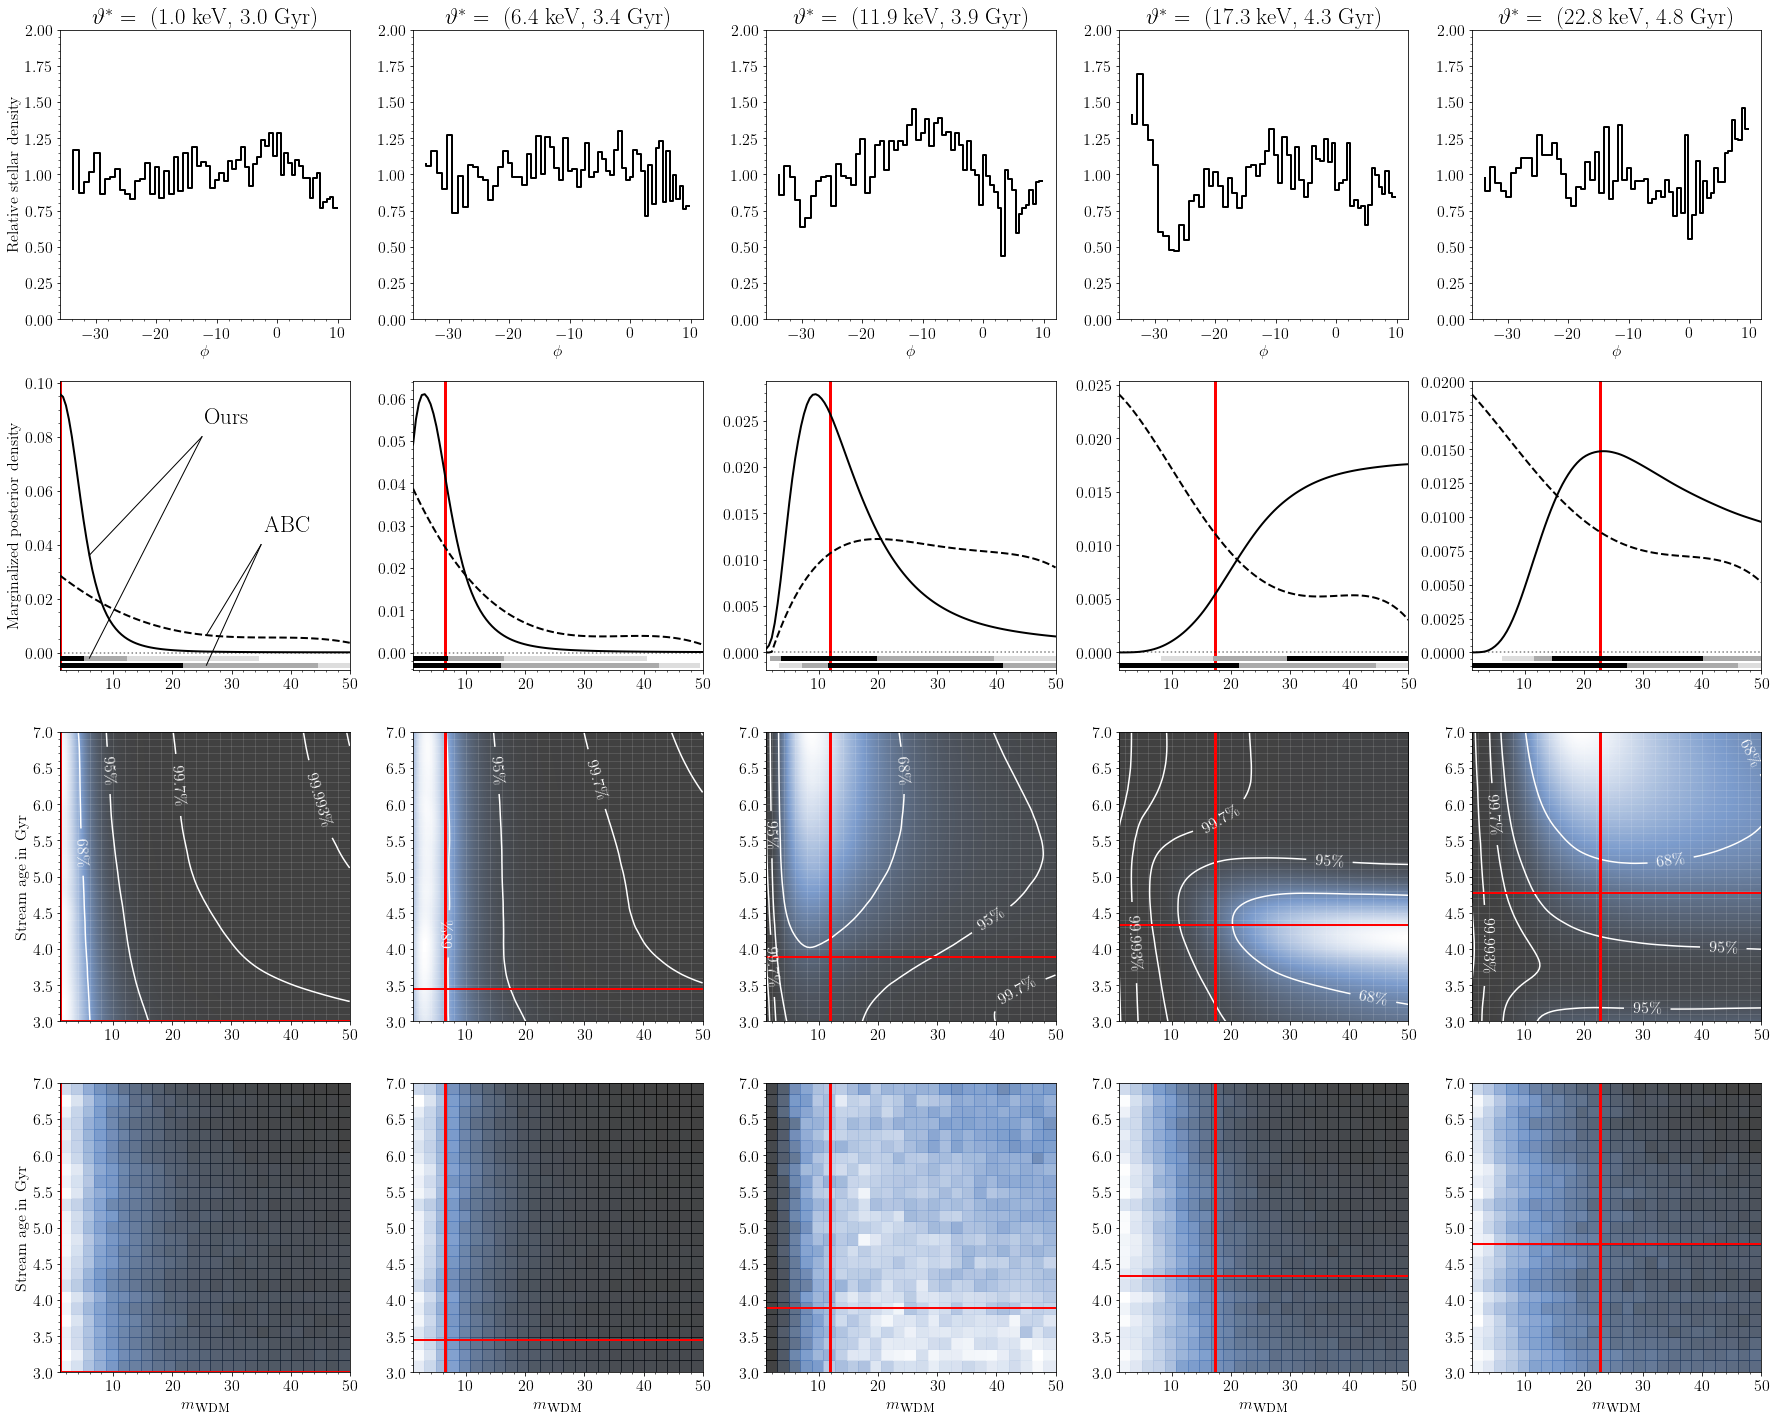

In [9]:
figure, axes = plt.subplots(4, 5, figsize=(25, 20))
bandwidth = .5

# Setup the titles.
axes[0][0].set_ylabel("Relative stellar density")
axes[1][0].set_ylabel("Marginalized posterior density")
# Plot first 5 observables.
for index in range(5):
    # Create the axes
    column = [axes[0][index], axes[1][index], axes[2][index], axes[3][index]]
    base = "../experiment-simulations/data/mock/block-" + str(index).zfill(5)
    age = np.load(base + "/ages.npy").reshape(-1)[0]
    mass = np.load(base + "/masses.npy").reshape(-1)[0]
    # Set the title
    column[0].set_title(r"$\vartheta^* =~($" + str(round(mass, 1)) + r" keV" + ", " + str(round(age, 1)) + " Gyr" + r"$)$", fontsize=23)
    # Show the observable
    ax = column[0]
    observable = np.load(base + "/density-contrasts-cut-noised.npy").reshape(-1)
    plot_stream(ax, phi, observable)
    
    
    # Show the 1D posterior
    ax = column[1]
    ax.axvline(mass, lw=3, color="red")
    
    ## ABC
    pdf = compute_1d_pdf_abc("abc-0000" + str(index), bandwidth=bandwidth)
    space = np.linspace(1, 50, 100)
    spline = UnivariateSpline(space, pdf, k=4)
    pdf = spline(space)
    pdf[pdf < 0] = 0
    pdf /= np.sum(pdf)
    ax.plot(space, pdf, lw=2, color="black", linestyle="dashed", label="ABC")
    pdf_abc = pdf

    ## Ours
    density = torch.from_numpy(observable.reshape(1, -1)).float()
    pdf, _ = compute_1d_pdf(r_1d, density)
    pdf /= np.sum(pdf)
    ax.plot(space, pdf, lw=2, color="black", label="Ours")
    ax.minorticks_on()
    ax.set_xlim([1, 50])
    pdf_ours = pdf
    

    ## Plot the contours
    ylims = ax.get_ylim()
    scale = 1 / (ylims[1] - ylims[0])
    ax.axhline(0, color="black", linestyle="dotted", alpha=.5)
    plot_1d_contours(ax, pdf_ours, height=-0.02 / scale)
    plot_1d_contours(ax, pdf_abc, height=-0.045 / scale)
    ax.set_ylim([-0.0625 / scale, None])
    
    ## Show the lines + label.
    if index == 0:
        i = 10
        # Ours
        ax.plot([space[i], 25], [pdf_ours[i], 0.08], lw=1, color="black")
        ax.plot([space[i], 25], [-0.02 / scale, 0.08], lw=1, color="black")
        ax.text(25.5, 0.085, "Ours", fontsize=23)
        # ABC
        i = 50
        ax.plot([space[i], 35], [pdf_abc[i], 0.04], lw=1, color="black")
        ax.plot([space[i], 35], [-0.045 / scale, 0.04], lw=1, color="black")
        ax.text(35.5, 0.045, "ABC", fontsize=23)

    
    ## Show the 2D posterior (ABC)
    ax = column[3]
    ax.axvline(mass, lw=3, color="red")
    ax.axhline(age, lw=2, color="red")
    samples = np.load("out/mock/abc-0000" + str(index) + "/samples.npy")
    ax.hist2d(samples[:,0], samples[:,1], bins=25, cmap=cmap, alpha=.75)
    ax.minorticks_on()
    ax.set_xlabel(r"$m_{\textsc{wdm}}$")
    ax.set_ylabel("Stream age in Gyr")
    ax.set_xticks([10, 20, 30, 40, 50])
    ax.set_yticks([3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7])
    ax.set_yticks
    #pdf_abc = compute_2d_pdf_abc("abc-0000" + str(index), bandwidth=bandwidth)
    #plot_2d_pdf(ax, pdf_abc)
    #plot_2d_contours(ax, pdf_abc)
    

    ## Show the 2D posterior (Ours)
    ax = column[2]
    ax.axvline(mass, lw=3, color="red")
    ax.axhline(age, lw=2, color="red")
    pdf_ours, _ = compute_2d_pdf(r_2d, density)
    plot_2d_pdf(ax, pdf_ours)
    plot_2d_contours(ax, pdf_ours)
    
    # Remove and set approrimate labels
    column[0].set_xlabel(r"$\phi$")
    column[1].set_xlabel(None)
    column[2].set_xlabel(None)
    if index != 0:
        column[1].set_ylabel(None)
        column[2].set_ylabel(None)
        column[3].set_ylabel(None)
    
    # Make square
    make_square(column[0])
    make_square(column[1])
    make_square(column[2])
    make_square(column[3])

figure.tight_layout()
figure.savefig("plots/abc-comparison-panel-1.pdf", bbox_inches='tight', transparent=True, pad_inches=0)
figure.show()

### Second row

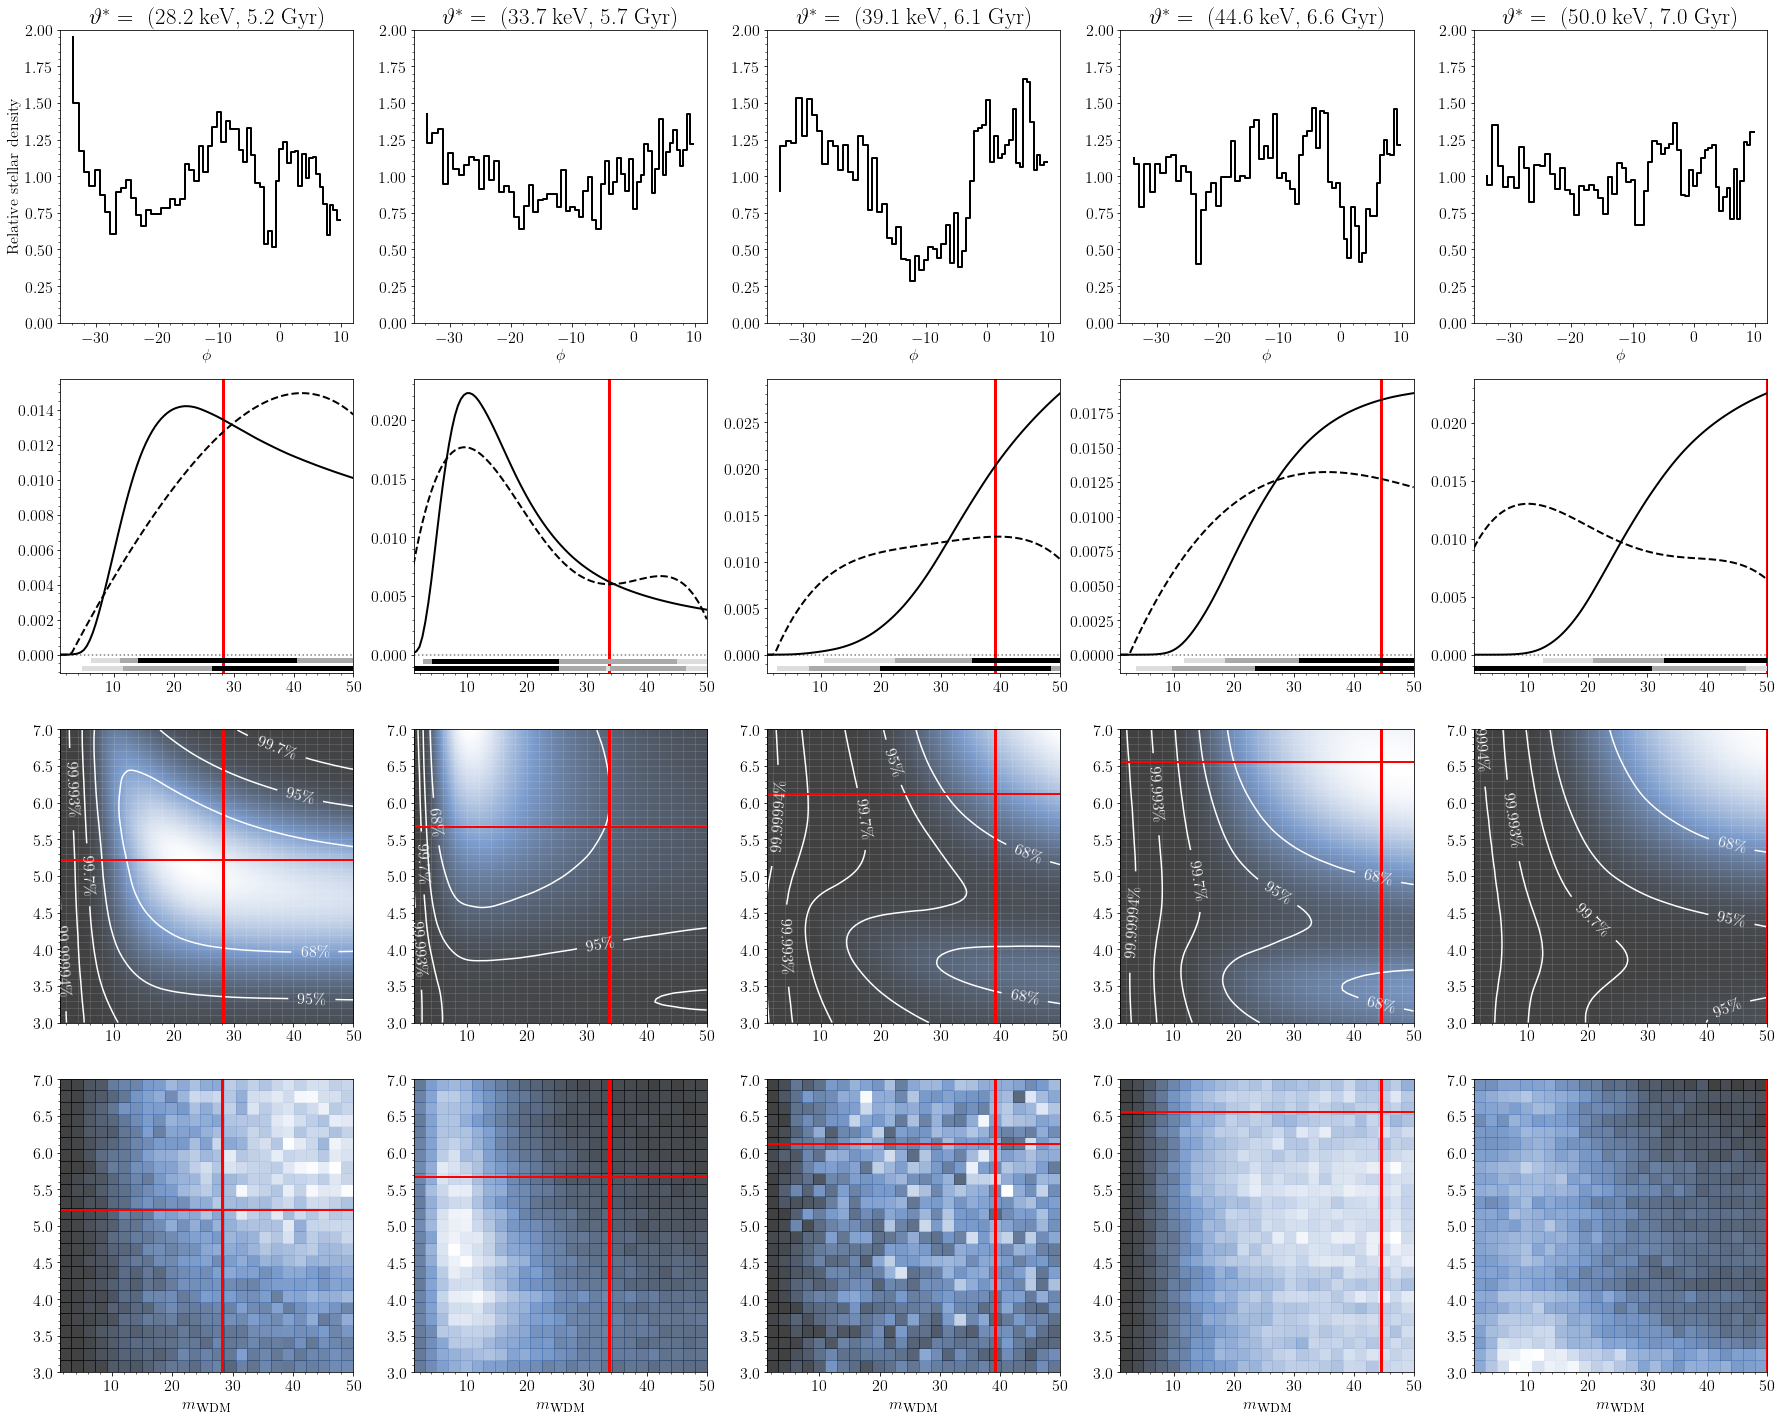

In [10]:
figure, axes = plt.subplots(4, 5, figsize=(25, 20))
bandwidth = .5

# Setup the titles.
axes[0][0].set_ylabel("Relative stellar density")
axes[1][0].set_ylabel("Marginalized posterior density")
# Plot first 5 observables.
for index in range(5):
    # Create the axes
    column = [axes[0][index], axes[1][index], axes[2][index], axes[3][index]]
    index += 5
    base = "../experiment-simulations/data/mock/block-" + str(index).zfill(5)
    age = np.load(base + "/ages.npy").reshape(-1)[0]
    mass = np.load(base + "/masses.npy").reshape(-1)[0]
    # Set the title
    column[0].set_title(r"$\vartheta^* =~($" + str(round(mass, 1)) + r" keV" + ", " + str(round(age, 1)) + " Gyr" + r"$)$", fontsize=23)
    # Show the observable
    ax = column[0]
    observable = np.load(base + "/density-contrasts-cut-noised.npy").reshape(-1)
    plot_stream(ax, phi, observable)
    
    
    # Show the 1D posterior
    ax = column[1]
    ax.axvline(mass, lw=3, color="red")
    
    ## ABC
    pdf = compute_1d_pdf_abc("abc-0000" + str(index), bandwidth=bandwidth)
    space = np.linspace(1, 50, 100)
    spline = UnivariateSpline(space, pdf, k=4)
    pdf = spline(space)
    pdf[pdf < 0] = 0
    pdf /= np.sum(pdf)
    ax.plot(space, pdf, lw=2, color="black", linestyle="dashed", label="ABC")
    pdf_abc = pdf

    ## Ours
    density = torch.from_numpy(observable.reshape(1, -1)).float()
    pdf, _ = compute_1d_pdf(r_1d, density)
    pdf /= np.sum(pdf)
    ax.plot(space, pdf, lw=2, color="black", label="Ours")
    ax.minorticks_on()
    ax.set_xlim([1, 50])
    pdf_ours = pdf
    

    ## Plot the contours
    ylims = ax.get_ylim()
    scale = 1 / (ylims[1] - ylims[0])
    ax.axhline(0, color="black", linestyle="dotted", alpha=.5)
    plot_1d_contours(ax, pdf_ours, height=-0.02 / scale)
    plot_1d_contours(ax, pdf_abc, height=-0.045 / scale)
    ax.set_ylim([-0.0625 / scale, None])
    
    ## Show the lines + label.
    if index == 0:
        i = 10
        # Ours
        ax.plot([space[i], 25], [pdf_ours[i], 0.08], lw=1, color="black")
        ax.plot([space[i], 25], [-0.02 / scale, 0.08], lw=1, color="black")
        ax.text(25.5, 0.085, "Ours", fontsize=23)
        # ABC
        i = 50
        ax.plot([space[i], 35], [pdf_abc[i], 0.04], lw=1, color="black")
        ax.plot([space[i], 35], [-0.045 / scale, 0.04], lw=1, color="black")
        ax.text(35.5, 0.045, "ABC", fontsize=23)

    
    ## Show the 2D posterior (ABC)
    ax = column[3]
    ax.axvline(mass, lw=3, color="red")
    ax.axhline(age, lw=2, color="red")
    samples = np.load("out/mock/abc-0000" + str(index) + "/samples.npy")
    ax.hist2d(samples[:,0], samples[:,1], bins=25, cmap=cmap, alpha=.75)
    ax.minorticks_on()
    ax.set_xlabel(r"$m_{\textsc{wdm}}$")
    ax.set_ylabel("Stream age in Gyr")
    ax.set_xticks([10, 20, 30, 40, 50])
    ax.set_yticks([3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7])
    ax.set_yticks
    #pdf_abc = compute_2d_pdf_abc("abc-0000" + str(index), bandwidth=bandwidth)
    #plot_2d_pdf(ax, pdf_abc)
    #plot_2d_contours(ax, pdf_abc)
    

    ## Show the 2D posterior (Ours)
    ax = column[2]
    ax.axvline(mass, lw=3, color="red")
    ax.axhline(age, lw=2, color="red")
    pdf_ours, _ = compute_2d_pdf(r_2d, density)
    plot_2d_pdf(ax, pdf_ours)
    plot_2d_contours(ax, pdf_ours)
    
    # Remove and set approrimate labels
    column[0].set_xlabel(r"$\phi$")
    column[1].set_xlabel(None)
    column[2].set_xlabel(None)
    if index != 0:
        column[1].set_ylabel(None)
        column[2].set_ylabel(None)
        column[3].set_ylabel(None)
    
    # Make square
    make_square(column[0])
    make_square(column[1])
    make_square(column[2])
    make_square(column[3])

figure.tight_layout()
figure.savefig("plots/abc-comparison-panel-2.pdf", bbox_inches='tight', transparent=True, pad_inches=0)
figure.show()